In [26]:
import numpy as np
import matplotlib.pyplot as pyplot
import pandas as pd
from scipy.interpolate import griddata
import matplotlib.colors as colors
from functools import reduce

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.model_selection import train_test_split, learning_curve, StratifiedShuffleSplit

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

import DataPreprocessing

## Obtaining and nicely arranging data

In [28]:
combs = ['1,4','1,5','1,6','2,4','2,5','2,6','3,4','3,5','3,6']
combs = ['1,3','1,4','2,3','2,4']
#combs = []

In [29]:
##Obtain & process data NPY
#me_train, mom_train_r = DataPreprocessing.npy('LO/MG_uuxg_2/me_3jet_1000000.npy', 'LO/MG_uuxg_2/mom_3jet_1000000.npy', ['1,3','2,3'], 1000, frac=1)
#me_test, mom_test_r = DataPreprocessing.npy('LO/MG_uuxg_2/me_3jet_100000.npy', 'LO/MG_uuxg_2/mom_3jet_100000.npy', ['1,3','2,3'], 1000, frac=1)
#me_train, mom_train_r = DataPreprocessing.npy('me_6jet_100000.npy', 'mom_6jet_100000.npy', combs, 10000, frac=1)
#me_test, mom_test_r = DataPreprocessing.npy('me_6jet_10000.npy', 'mom_6jet_10000.npy', combs, 10000, frac=1)

me_train, mom_train_r = DataPreprocessing.npy('LO/MG_uuuxux/me_4jet_1000000', 'LO/MG_uuuxux/mom_4jet_1000000', combs, 1000, frac=1)
me_test, mom_test_r = DataPreprocessing.npy('LO/MG_uuuxux/me_4jet_100000', 'LO/MG_uuuxux/mom_4jet_100000', combs, 1000, frac=1)


Adding some extra features

## Single Test

In [35]:
mom_train = np.append(mom_train_r, DataPreprocessing.mandel_creation(combs, mom_train_r).T, axis=1)
mom_test = np.append(mom_test_r, DataPreprocessing.mandel_creation(combs, mom_test_r).T, axis=1)

##Data transformation
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kbins', KBinsDiscretizer(n_bins=200)) #Checking convergence as bins.
])
 
mom_train = pipeline.fit_transform(mom_train_r) #Rescale on training set
mom_test = pipeline.transform(mom_test_r) #Rescale on test set

In [36]:
linreg = LinearRegression().fit(mom_train, me_train)

me_predict_lin = linreg.predict(mom_test) #Prediction on test set
lin_mse = mean_squared_error(me_test, me_predict_lin) 
print('RMSE: {}'.format(np.sqrt(lin_mse)))


lin_perc = np.mean(100*np.divide(np.abs(me_test - me_predict_lin), me_test))
print('Percentage Error: {}'.format(lin_perc))

RMSE: 3.545482299350183e+31
Percentage Error: 683.8817340437587


In [45]:
print(np.std(me_test))

1261945434.3389325


Plotting Learning Curve

In [7]:
##Plotting a Learning Curve
split = StratifiedShuffleSplit() #Collects data evenly about mean to put into validation sets
train = split.split(mom_train, pd.cut(me_train, bins = 200)) #But are we testing on something we've trained..?

train_sizes, train_scores, test_scores = learning_curve(
        linreg, mom_train, me_train, scoring='neg_mean_squared_error',
        cv=5, shuffle=True, train_sizes=np.linspace(0.1, 1, 6), 
        n_jobs=1, verbose=1)

[learning_curve] Training set sizes: [ 800 2240 3679 5120 6560 8000]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.5s finished


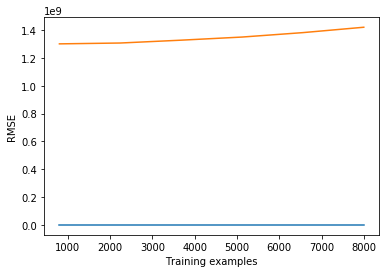

In [8]:
pyplot.figure()

train_scores_mean = np.sqrt(-np.mean(train_scores, axis=1))
test_scores_mean = np.sqrt(-np.mean(test_scores, axis=1))

pyplot.plot(train_sizes, train_scores_mean)
pyplot.plot(train_sizes, test_scores_mean)

pyplot.xlabel("Training examples")
pyplot.ylabel("RMSE")
pyplot.savefig('LearningCurveKBins')

Error Distribution 3-jets

In [16]:
#s12, s13, s23 = DataPreprocessing.mandel_creation(['3,4','3,5','4,5'], mom_test)
s12, s13, s23 = DataPreprocessing.mandel_creation(['1,2','1,2,4','2,3,4'], mom_test_r)
S = s12 + s13 + s23

In [17]:
x1 = np.divide(s12, 1000000)
x2 = np.divide(s13, 1000000)
x3 = np.divide(s23, 1000000)

x2i = np.linspace(0, 1, 500) #x1 coordinates
x3i = np.linspace(0, 1, 500) #x2 coordinates
X2i, X3i = np.meshgrid(x2i, x3i) #2d regularly spaced grid of coordinates.

In [18]:
#Value at grid coordinate is mapped to the nearest actual datapoint.
#grid = griddata((x2, x3), 100*np.divide(np.abs(me_test - me_predict_lin), me_test), (X2i, X3i), method='linear')
grid = griddata((x2, x3), me_test, (X2i, X3i), method='linear')

Text(0.5,0,'x3')

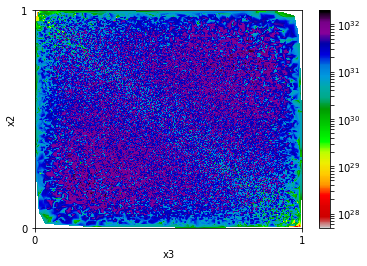

In [19]:
fig, ax = pyplot.subplots()
im = ax.pcolor(grid, cmap = 'nipy_spectral_r', norm = colors.LogNorm()) #color map of coord grid
cbar = ax.figure.colorbar(im)
#cbar.set_label('Percentage Error')

ax.set_xticks([0, 500])
ax.set_xticklabels([0, 1])
ax.set_yticks([0, 500])
ax.set_yticklabels([0, 1])


ax.set_ylabel('x2')
ax.set_xlabel('x3')

## Plot accuracy vs number of bins

In [20]:
def changeBins(n_bins, input_train, input_test, output_train, output_test):
    ##Data transformation
    pipeline = Pipeline([
        ('scaler', StandardScaler()), #Rescale Data.
        ('kbins', KBinsDiscretizer(n_bins=n_bins)) #Checking convergence as bins.
    ])

    temp_train = pipeline.fit_transform(input_train) #Rescale on training set
    temp_test = pipeline.transform(input_test) #Rescale on test set
    
    linreg = LinearRegression().fit(temp_train, output_train)

    me_predict = linreg.predict(temp_test) #Prediction on test set
    lin_mse = mean_squared_error(output_test, me_predict) 
    
    lin_perc = np.mean(100*np.divide(np.abs(output_test - me_predict), output_test))
    
    return lin_perc

In [27]:
##Obtain & process data
me_train, mom_train_r = DataPreprocessing.npy('LO/MG_uuuxux/me_4jet_1000000', 'LO/MG_uuuxux/mom_4jet_1000000', 
                                            ['1,3','1,4','2,3','2,4'], 10000, frac=1)
me_test, mom_test_r = DataPreprocessing.npy('LO/MG_uuuxux/me_4jet_100000', 'LO/MG_uuuxux/mom_4jet_100000', 
                                          ['1,3','1,4','2,3','2,4'], 10000, frac=1)

train = reduce(np.multiply, DataPreprocessing.mandel_creation(['1,3,4',',2,3,4','1,2,3','1,2,4'], mom_train_r))**0.5
test = reduce(np.multiply, DataPreprocessing.mandel_creation(['1,3,4',',2,3,4','1,2,3','1,2,4'], mom_test_r))**0.5
mom_train = np.multiply(mom_train, train)
mom_test = np.multiply(mom_test, test)

mom_train = np.append(mom_train, DataPreprocessing.mandel_creation(combs, mom_train_r).T, axis=1)
mom_test = np.append(mom_test, DataPreprocessing.mandel_creation(combs, mom_test_r).T, axis=1)

n_bins_arr = range(100, 1000, 100)
result = []
for n_bins in n_bins_arr:
    temp = changeBins(n_bins, mom_train, mom_test, me_train, me_test)
    print(temp)
    result.append(temp)

ValueError: invalid literal for int() with base 10: ''

In [ ]:
pyplot.xlabel('Number of Bins')
pyplot.ylabel('% Error')
pyplot.title('Point k at which kBins overfits')
pyplot.plot(n_bins_arr, result)
pyplot.savefig('RMSE_kBins_Overfit')

In [38]:
print(np.mean(me_test))

27820.578600538574


In [39]:
print(np.std(me_test))

41758.90805249425
